# Large-Scale Image Processing On Your Laptop (and elsewhere)

### ImageXD 2018 Tutorial

---
### Goals of this workshop:

* get acquanted with the Python [Dask](http://dask.pydata.org/en/latest/) Library
* learn how to execute basic operations on large images which cannot fit in RAM
* learn about the concepts of lazy evaluation and task scheduling graphs
* learn how to work with [Dask Arrays](http://dask.pydata.org/en/latest/array.html)
* learn how to work with [Dask Delayed](http://dask.pydata.org/en/latest/delayed.html)

---
### Motivation

What is this tutorial about? Researchers across domains get overloaded with image data which their traditional processing workflows are incapable to handle. Usually they are faced with two possible options: 
* move the processing to large machines/clusters
* modify their methods to access the image data only pieces at a time.

<!---* Mechanical Engineering - microbubbles
* Oceanography - sonar, video
* Neuroscience - calcium imaging, fMRI
* etc--->


Scientists like to test out things on their laptops, and later move to clusters, without having to modify their code a lot.

[Dask](http://dask.pydata.org/en/latest/) is a Python Library which makes this possible: 
* can perform computations on images which cannot fit into RAM
* has interface similar to `numpy` and `scipy`
* the same code used on your laptop can be run on a distributed cluster


The Dask library provides several useful objects
* [Dask Arrays](http://dask.pydata.org/en/latest/array.html) (for numpy-like operations) *
* [Dask DataFrames](http://dask.pydata.org/en/doc-test-build/dataframe.html) (for pandas-like operations)
* [Dask Bags](http://dask.pydata.org/en/latest/bag.html) (for unstructured-data-like operations, such as text)
* [Dask Delayed](http://dask.pydata.org/en/latest/delayed.html) (for general functions and operations) *

We will be working with a [dataset of leaf images](https://archive.ics.uci.edu/ml/datasets/leaf) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/).The description is in
*'Evaluation of Features for Leaf Discrimination', Pedro F.B. Silva, Andre R.S. Marcal, Rubim M. Almeida da Silva (2013). Springer Lecture Notes in Computer Science, Vol. 7950, 197-204.*

In [7]:
import os
path = os.path.join('data','leaf','RGB')

In [3]:
# this cell is dealing with entry 87
#from skimage.io import imread
#from glob import glob
# make it work on any OS
#filenames = glob(path+'*/*.JPG')
#for file in filenames:
#    im = imread(file)
#    if im.shape[0]!=960:
#        print(file)

In [4]:
# some preliminary imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### Dask Arrays

Dask arrays are similar to numpy arrays, except that they are chunked into small pieces.

In [5]:
import dask.array as da
from dask.array.image import imread

We can read a collection of images into a dask array.

In [10]:
#leaf_images = imread(path+"*.jpg")
leaf_images = imread(os.path.join(path,'*','*.JPG'))

Let's look at it:

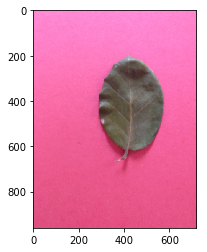

In [11]:
plt.imshow(leaf_images[0,:,:,:])

In [12]:
# saving the dimensions
T, m, n, d = leaf_images.shape

Each image is a separate chunk.

*The images are not loaded into RAM!!!!*

We can do computations on the dask array as long as individual chunks (and the computations on them) fit into RAM.

Let's  find the mean image:

In [13]:
%%time
leaf_images.mean(axis=0)

CPU times: user 12.6 ms, sys: 870 µs, total: 13.4 ms
Wall time: 21.8 ms


dask.array<mean_agg-aggregate, shape=(960, 720, 3), dtype=float64, chunksize=(960, 720, 3)>

The above statement creates another dask array, which is not loaded into RAM, i.e. it is not calculated yet. 
It waits for us tell dask explicitly when to do the calculation using the `compute` command.This is called [lazy evaluation](https://en.wikipedia.org/wiki/Lazy_evaluation).

In [32]:
%%time
mean_leaf_image = leaf_images[:,:,:,0].mean(axis=0).compute()

CPU times: user 31.8 s, sys: 8.65 s, total: 40.5 s
Wall time: 9.52 s


In [33]:
mean_leaf_image.shape

(960, 720)

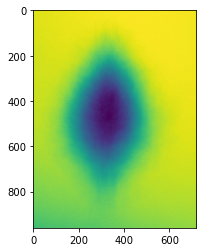

In [34]:
plt.imshow(mean_leaf_image)

***Important: only the final image is stored in RAM, which is smaller than the original collection!***

Note: if we pass a dask array to a function not supporting dask arrays, it often gets converted to an in-memory numpy array and evaluated.

A lot of other functions to perform on images using the [Dask API](http://dask.pydata.org/en/latest/array-api.html).

#### Exercise: visualizing graphs

You can visualize the individual steps of your computation as a graph. For example, this is the graph for computing a mean of an array consisting of 4 chunks:

<center>*Mean of a 2D Array*</center>
<img src="dask_graph.png" width="300" height="200" >

For that you need to install an additional package.

```
conda install graphviz

```
Then you can import `graphviz` in Python and for any dask array run

```
dask_array_name.visualize()
```

Try visualizing the graph for mean of all images. If the visualization does not look good in the notebook you can save it as a `.svg` file and look at the image via your browser:

```
dask_array_name.visualize('graph.svg')
```

In [45]:
leaf_images[:,:,:,0].mean(axis=0).visualize('graph.svg',optimize_graph= True)

#### Exercise: simple calculations
* calculate the approximate area of each leaf

In [35]:
from dask.diagnostics import ProgressBar

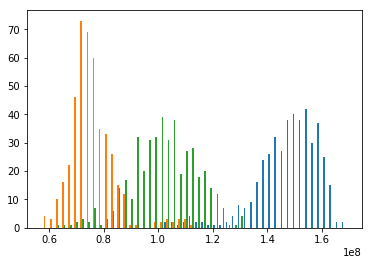

In [46]:
# mean for each RGB color for each image
areas = leaf_images.sum(axis=[1,2])
fig = plt.hist(areas.compute(),bins = 50)

#### Monitoring Performance

In [47]:
from dask.diagnostics import ProgressBar

In [53]:
# Single machine progress bar
res =leaf_images.mean(axis=[1,2])
with ProgressBar():
    out = res.compute()

[########################################] | 100% Completed |  8.2s


In [54]:
# cpu, ram performance
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
rprof = ResourceProfiler(dt=0.5)

res = leaf_images[:,:,:,0].mean(axis=0)
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof,CacheProfiler() as cprof:
    out = res.compute()
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

Column(id='54777ba1-95ef-4d4c-bddc-0b58622ba2ca', ...)

In [ ]:
# min across all colors for each image

In [50]:
# max for each color for each image

In [ ]:
# max across all colors for each image

#### Distributed Computing

In [64]:
# Distributed scheduler 

from dask.distributed import Client

client = Client()  # use dask.distributed by default

From now on any `compute` command will use the distributed scheduler.

In [66]:
leaf_images.mean([1,2]).compute()

array([[ 223.90436921,  102.60029369,  153.24776765],
       [ 231.06337963,  101.46901042,  144.00368056],
       [ 231.95026042,  101.98655816,  142.983614  ],
       ..., 
       [ 213.90324074,   85.5297555 ,  155.92697049],
       [ 226.90309028,   93.15233796,  176.20206019],
       [ 220.82214265,   90.55375579,  164.09816406]])

In [68]:
# Distributed Progress Bar
from dask.distributed import progress
leaf_images = leaf_images.persist()  # start computation in the background
progress(leaf_images)      # watch progress
leaf_images.compute()      # convert to final result when done if desired

array([[[[255, 135, 209],
         [253, 133, 207],
         [252, 132, 206],
         ..., 
         [255, 134, 203],
         [254, 133, 202],
         [254, 133, 202]],

        [[254, 134, 208],
         [252, 132, 206],
         [252, 132, 206],
         ..., 
         [255, 134, 203],
         [254, 133, 202],
         [253, 132, 201]],

        [[252, 132, 206],
         [252, 132, 206],
         [252, 132, 206],
         ..., 
         [251, 130, 199],
         [253, 132, 201],
         [255, 135, 204]],

        ..., 
        [[225,  84, 136],
         [222,  81, 133],
         [220,  79, 131],
         ..., 
         [229,  81, 131],
         [229,  81, 131],
         [231,  83, 133]],

        [[227,  86, 138],
         [224,  83, 135],
         [222,  81, 133],
         ..., 
         [232,  84, 134],
         [231,  83, 133],
         [233,  85, 135]],

        [[223,  82, 134],
         [222,  81, 133],
         [223,  82, 134],
         ..., 
         [233,  85, 135],
  

We observe that some of the images have a very diffent intensity range.

#### A simple leaf classifier

In [55]:

labels = np.logical_and(areas>2000000,areas<2100000)

In [56]:
plt.imshow(leaf_images[np.logical_not(labels),:,:][20,:,:])

TypeError: '<' not supported between instances of 'list' and 'int'

Key Points:

* dask arrays are not loaded into memory until you start doing computations on them
* computations on dask arrays are not executed until you ask for them via `.compute`()
* passing a `dask.array` to a `numpy` or `matplotlib` function might work but the computation will be done in memory

---
### Perform Principal Component Analysis on a Collection of Images

PCA can be perform by the following steps:
* center the images
* reshape the data into a matrix # features x # observations format
* perform SVD on the data matrix D = USV^T
* flip the signs to make the output deterministic
* reshape the columsn of U into an image format -> these are the principal directions

In [69]:
# center the images
leaf_images_centered = leaf_images - leaf_images.mean(axis = 0)

In [70]:
# create a data matrix - # features x # observations
data = leaf_images[:,:,:,0].reshape((-1,m*n))
print(data.shape)
data

(442, 691200)


dask.array<reshape, shape=(442, 691200), dtype=uint8, chunksize=(1, 691200)>

In [71]:
# picture for structure of data to work

In [72]:
help(da.linalg.tsqr)

# Tall-and-Skinny QR algorithm

# It requires that the input array have a
#    single column of blocks, each of which fit in memory.
data.shape


Help on function tsqr in module dask.array.linalg:

tsqr(data, name=None, compute_svd=False)
    Direct Tall-and-Skinny QR algorithm
    
    As presented in:
    
        A. Benson, D. Gleich, and J. Demmel.
        Direct QR factorizations for tall-and-skinny matrices in
        MapReduce architectures.
        IEEE International Conference on Big Data, 2013.
        http://arxiv.org/abs/1301.1071
    
    This algorithm is used to compute both the QR decomposition and the
    Singular Value Decomposition.  It requires that the input array have a
    single column of blocks, each of which fit in memory.
    
    If blocks are of size ``(n, k)`` then this algorithm has memory use that
    scales as ``n**2 * k * nthreads``.
    
    Parameters
    ----------
    
    data: Array
    compute_svd: bool
        Whether to compute the SVD rather than the QR decomposition
    
    See Also
    --------
    
    dask.array.linalg.qr - Powered by this algorithm
    dask.array.linalg.svd - Pow

(442, 691200)

In [75]:
# svd expects only one column block
data = data.rechunk((13,m*n))
data

dask.array<rechunk-merge, shape=(442, 691200), dtype=uint8, chunksize=(13, 691200)>

In [76]:
u, s, vt = da.linalg.svd(data)

In [77]:
from dask import compute

In [78]:
%%time
# u = u[:,:10].compute()
u, s, vt = compute(u[:,:10],s[:10],vt[:,:10])

distributed.batched - INFO - Batched Comm Closed: BrokenPipeError: [Errno 32] Broken pipe
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/distributed/utils.py", line 370, in log_errors
    yield
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/distributed/scheduler.py", line 892, in remove_worker
    self.transitions(recommendations)
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/distributed/scheduler.py", line 2852, in transitions
    new = self.transition(key, finish)
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/distributed/scheduler.py", line 2809, in transition
    recommendations = func(key, *args, **kwargs)
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/distributed/scheduler.py", line 2530, in transition_processing_released
    assert key in self.waiting_data[dep]
AssertionError


KeyboardInterrupt: 

distributed.utils - ERROR - ("('imread-867fc7bcfc673b813c773a051f20f52c', 347, 0, 0, 0)", 'tcp://127.0.0.1:51626')
Traceback (most recent call last):
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/distributed/utils.py", line 212, in f
    result[0] = yield make_coro()
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 1063, in run
    yielded = self.gen.throw(*exc_info)
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/distributed/client.py", line 1551, in _get
    result = yield self._gather(packed)
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result(

tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x11054cd08>, <tornado.concurrent.Future object at 0x110542da0>)
Traceback (most recent call last):
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 605, in _run_callback
    ret = callback()
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 626, in _discard_future_result
    future.result()
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 1063, in run
    yielded = self.gen.throw(*exc_info)
  File "/Users/valentina/anaconda/lib/python3.6/site-

tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x110533b70>, <tornado.concurrent.Future object at 0x11052c5f8>)
Traceback (most recent call last):
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 605, in _run_callback
    ret = callback()
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 626, in _discard_future_result
    future.result()
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 1063, in run
    yielded = self.gen.throw(*exc_info)
  File "/Users/valentina/anaconda/lib/python3.6/site-

In [ ]:
from scipy import linalg

In [ ]:
%%time
u, s, vt = linalg.svd(data,full_matrices = False)

In [ ]:
# I should have an example 

Recall that principal components are unique up to a sign change. So in order that we all obtain the same result we can flip the sings based on vt using the following `svd_flip` function.

In [ ]:
# flip signs based on vt
from sklearn.utils.extmath import svd_flip
u, vt = svd_flip(u,vt)

In [ ]:
# convert the components to back to images
u = u.reshape(256,256,3,10)

In [ ]:
# plot the results
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow((u[:,:,:,i]-u.min())/(u.max() - u.min()))
    plt.title('Mode '+str(i+1))

Key Points:
* some dask functions are strict about the form of the chunks
* not all familiar methods are implemented within dask, but you can still run them using the existing base functions
* on a regular laptop complex dask algorithms might not be faster than numpy equivalents but they do not overload the memory

Some of the new functionality of dask for data analysis is implemented within the separate [`dask-ml`](http://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.decomposition.PCA.html) package. It is under active development so expect changes and new stuff!

----
PCA through [`dask-ml`](http://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.decomposition.PCA.html).

In [ ]:
# 

In [181]:
from dask_ml.decomposition import PCA 

In [182]:
pca = PCA(n_components=10)

In [183]:
data

dask.array<rechunk-merge, shape=(442, 691200), dtype=uint8, chunksize=(13, 691200)>

In [184]:
pca.fit(data)

PCA(copy=True, iterated_power=0, n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [185]:
print(pca.components_.shape)
u = pca.components_.reshape(-1,m,n)

(10, 691200)


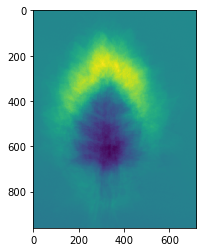

In [186]:
plt.imshow(u[2,:,:])

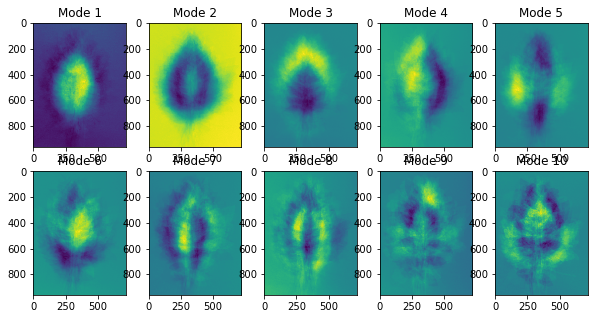

In [188]:
# plot the results
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    #plt.imshow((u[i,:,:]-u.min())/(u.max() - u.min()))
    plt.imshow(u[i,:,:])
    plt.title('Mode '+str(i+1))

In [189]:
help(pca.fit)

Help on method fit in module dask_ml.decomposition.pca:

fit(X, y=None) method of dask_ml.decomposition.pca.PCA instance
    Placeholder for fit. Subclasses should implement this method!
    
    Fit the model with X.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples and
        n_features is the number of features.
    
    Returns
    -------
    self : object
        Returns the instance itself.



#### Extra Exercises

**Exercise: chunking performance**

Try using different chunk sizes and compare the speed of the svd computation.

**Exercise: faster svd**

The cells dataset can be loaded into RAM on most laptops so you can compare the speed with running the [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) using the `scikit-learn` package. You will notice that it is actually faster than the dask svd. The reason is that when the data is too big the existing packages by default do not compute the full `svd` , instead they implement a randomized svd algorithm. Compare the speed when passing the parameter `svd_solver = full`. 

Dask has the corresponding implementation in `da.linalg.svd_compressed`. 

In [ ]:
help(da.linalg.svd_compressed)

Compare the speed, compare the results. Can you find the parameters to obtain similar performance?

----
### Perform Complex Operations on a Collection of Images.

We consider the following scenario: 

we have a big pile of images and we need to perform the same pre-processing step to each image and in the end store the result in one array for further processing.

Clearly we can achieve this by writing a `for-loop` which processes each image and stores the result. 

To accomplish this in a distributed manner we can use `dask`'s [delayed](http://dask.pydata.org/en/latest/delayed.html) functionality. It allows to parallelize our own Python functions.

In [ ]:
from dask import delayed

We recall that the images had different intensity ranges: let's rescale them so that they are always between 0 and 255. We can achieve that with the scikit-image [exposure.rescale_intensity](http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.rescale_intensity) function.

In [ ]:
from skimage.exposure import rescale_intensity

We can convert a regular Python function to a dask delayed function:

In [ ]:
rescale_intensity_dask = delayed(rescale_intensity)

In [ ]:
# create delayed evaluations
lazy_values = [rescale_intensity_dask(im) for im in leaf_images]

In [ ]:
# create a list of dask arrays
arrays = [da.from_delayed(lazy_value, shape=(m,n), dtype=leaf_images.dtype) for lazy_value in lazy_values]

In [125]:
from skimage.segmentation import felzenszwalb
from skimage.segmentation import slic
from skimage.segmentation import quickshift
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local

In [140]:
#res = slic(leaf_images[0,:,:,:],n_segments = 2,compactness = 50, sigma=10)
res = threshold_local(leaf_images[0,:,:,0],block_size = 101)
res = threshold_otsu(leaf_images[0,:,:,0].compute())

In [141]:
leaf_images[0,:,:,0].min().compute()

57

Help on function threshold_otsu in module skimage.filters.thresholding:

threshold_otsu(image, nbins=256)
    Return threshold value based on Otsu's method.
    
    Parameters
    ----------
    image : (N, M) ndarray
        Grayscale input image.
    nbins : int, optional
        Number of bins used to calculate histogram. This value is ignored for
        integer arrays.
    
    Returns
    -------
    threshold : float
        Upper threshold value. All pixels with an intensity higher than
        this value are assumed to be foreground.
    
    Raises
    ------
    ValueError
         If `image` only contains a single grayscale value.
    
    References
    ----------
    .. [1] Wikipedia, http://en.wikipedia.org/wiki/Otsu's_Method
    
    Examples
    --------
    >>> from skimage.data import camera
    >>> image = camera()
    >>> thresh = threshold_otsu(image)
    >>> binary = image <= thresh
    
    Notes
    -----
    The input image must be grayscale.



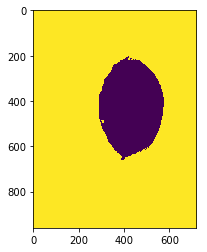

In [147]:
plt.imshow(img>res)
help(threshold_otsu)

TypeError: Invalid dimensions for image data

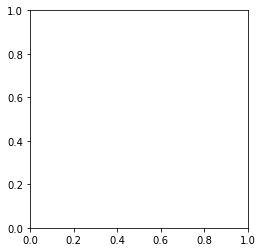

In [142]:
plt.imshow(res)
#plt.imshow(leaf_images[0,:,:,:])

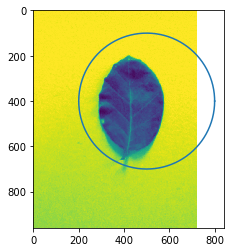

In [113]:
img = (leaf_images[0,:,:,0])

s = np.linspace(0, 2*np.pi, 400)
x = 500 + 300*np.cos(s)
y = 400 + 300*np.sin(s)
init = np.array([x, y]).T
plt.imshow(img)
plt.plot(x,y)


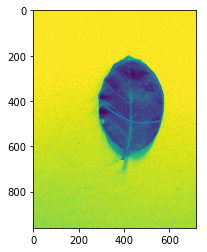

In [94]:
res = active_contour(leaf_images[0,:,:,0],init,alpha = 0.1)
plt.imshow(img)
plt.plot(res[:,0],res[:,1])

In [89]:
type(arrays)

NameError: name 'arrays' is not defined

We can see that the type of this final result is a list and each entry is a `dask array`:

In [49]:
print(type(arrays))
print(type(arrays[0]))

NameError: name 'arrays' is not defined

We can convert them to a dask array:

In [ ]:
stack = da.stack(arrays, axis=0) 

In [ ]:
stack

Note: this chunksize is useful when doing individual operations on images, not across images!

In [ ]:
plt.subplot(1,2,1)
plt.imshow(cell_images[100,:,:,:])
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(stack[100,:,:,:])
plt.title('Rescaled Image')

In [ ]:
stack_max = stack.max(axis = [1,2]).compute()
print(stack_max)

Now the maximum is always 255.

In [ ]:
plt.plot(stack_max,'ko')

In [ ]:
#(this example is not very useful in this case)
# segmentation and histogram not that great either
# extract boundaries 
# edge detection

Note: there are alternative approaches to applying a function to a collection of objects in a distributed manner, `dask delayed` is most useful when we want to store the results in a distributed array on which to perform further operations.

Key Points:
* any Python function can be converted to a dask function using `delayed`
* it is most useful to use `dask delayed` when the output can be stored in a dask object
* the power of `dask delayed` is more noticeable on many-core machines or clusters

#### Extra Exercises

**Exercise: segmenting images**

One approach to segment color images is using the k-means algorithm in color space. The `scikit-image` [`segmentation.slic`](http://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic) function is a good candidate:

In [ ]:
#from skimage.segmentation import find_boundaries
from skimage.measure import find_contours
find_contours_dask = delayed(find_contours)
lazy_values = [find_contours_dask(im,100) for im in leaf_images]
# create a list of dask arrays
arrays = [da.from_delayed(lazy_value, shape=(m,n), dtype=leaf_images.dtype) for lazy_value in lazy_values]
arrays[0]
# we do not know the size in advance

In [ ]:
plt.imshow(arrays[0][0,:],arrays[0][1,:])

In [ ]:
arrays[0]

In [ ]:
help(find_boundaries)

In [ ]:
from skimage.feature import canny
canny_dask = delayed(canny)

In [ ]:
lazy_values = [canny_dask(im) for im in leaf_images]

In [ ]:
# create a list of dask arrays
arrays = [da.from_delayed(lazy_value, shape=(m,n), dtype=leaf_images.dtype) for lazy_value in lazy_values]

In [ ]:
stack = da.stack(arrays, axis=0) 
stack

In [ ]:
plt.imshow(stack[0,:,:])

Apply the function to each image in the collection using `dask delayed`.

In [ ]:
# segmenta boundries and then function of the boundary
# rescale down

Hint: first test the segmentation on a single image to select appropriate parameters.

Compare the speed of this approach to applying the algorithm through a for loop.

#### Exercise: calculating histograms

Use the same approach as above to calculate the histogram for each image. In the new array each image is represented by its histogram. You can further try a clustering algorithm to cluster the images based on their histograms.

----
### Further Resources
* [Scipy 2016 Parallel Python Tutorial](https://www.youtube.com/watch?v=5Md_sSsN51k&list=PLYx7XA2nY5Gf37zYZMw6OqGFRPjB1jCy6&index=13) - comparison of different approaches for parallelization in Python
* [Distributed Images Blog](http://matthewrocklin.com/blog/work/2017/01/17/dask-images) - an example of processing a large image dataset on an Amazon EC2 cluster 
* [Dask on an Amazon EC2 cluster](https://github.com/dask/dask-ec2) - tool to start up a dask EC2 cluster

In [ ]:
data = leaf_images.reshape([leaf_images.shape[0],-1]).rechunk((100,m*n))

In [ ]:
data

In [ ]:
pca = PCA(n_components = 10)

In [ ]:
pca.fit(data)

In [ ]:
plt.imshow(pca.components_.reshape((-1,m,n))[4,:,:], cmap = 'jet')

In [ ]:
u = pca.components_.reshape((-1,m,n))

In [ ]:
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    #plt.imshow((u[i,:,:]-u.min())/(u.max() - u.min()))
    plt.imshow((u[i,:,:]))
    plt.title('Mode '+str(i+1))

---
Other

In [ ]:
from glob import glob

In [ ]:
filenames = glob("data/images/*.jpg")

In [ ]:
from skimage.io import imread, imsave

In [ ]:
sizes = []
for file in filenames:
    im = imread(file)
    sizes.append(im.shape)

In [ ]:
new_size = np.array(sizes).max(axis = 0)


In [ ]:
plt.imshow(im)

In [ ]:
im.resize((1000,1000))
print(type(im))
plt.imshow(im)

In [ ]:
def impad(im, new_size):
    pad_sizes = ((int(np.floor((new_size[0]-im.shape[0])/2)),int(np.ceil((new_size[0]-im.shape[0])/2))), (int(np.floor((new_size[1]-im.shape[1])/2)),int(np.ceil((new_size[1]-im.shape[1])/2))))
    im_padded = np.pad(im,pad_sizes,'edge')
    return(im_padded)

In [ ]:
for file in filenames:
    im = imread(file)
    imsave('data/images_padded/'+file.split('/')[-1], impad(im, new_size))

In [ ]:
filenames_padded = glob('data/images_padded/*.jpg')
for file in filenames_padded:
    im = imread(file)
    print(im.shape)

In [ ]:
filenames_padded = glob('data/images_padded/*.jpg')
for file in filenames_padded:
    im = imread(file)
    imsave(file,rescale(im, 0.25))

In [ ]:
plt.imshow(im)

In [ ]:
help(im.rescale)

In [ ]:
from skimage.transform import rescale